# Universal differential equation for the SIR model

In this script, we investigate the case that only a subset of species can be observed, which occurs often in experimental studies.

In [75]:
# SciML Tools
using OrdinaryDiffEq, SciMLSensitivity, Optimization, OptimizationOptimisers, OptimizationOptimJL

# Standard Libraries
using LinearAlgebra, Statistics, Random, Distributions

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs
gr()

# Set a random seed for reproducible behaviour
rng = StableRNG(111);

### Define the SIR dynamics and solve the ODE

In [76]:
function sir!(du, u, p, t)
    β, γ, N = p
    du[1] = -β*u[1]*u[2]/N
    du[2] = β*u[1]*u[2]/N - γ*u[2]
    du[3] = γ*u[2]
end

p_ODE = [0.6, 0.3, 1.0]
u0 = [0.999, 0.001, 0.0]
tspan = (0.0, 40.0);

In [77]:
prob = ODEProblem(sir!, u0, tspan, p_ODE)
sol = solve(prob, Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = 1.0);

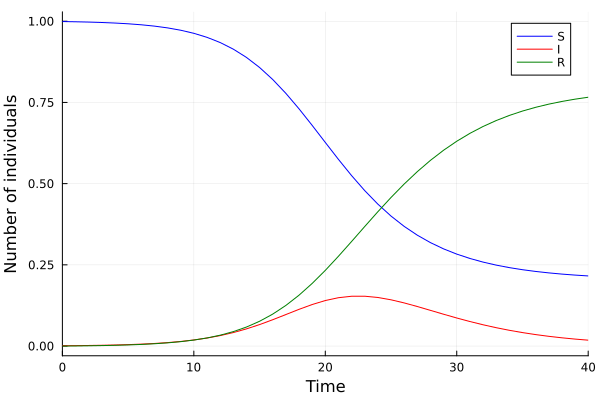

In [78]:
plot(sol, xlabel = "Time", ylabel = "Number of individuals", labels = ["S" "I" "R"], color = [:blue :red :green])

### Extract observable state and add multiplicative log-normal noise

In [79]:
t = sol.t
X = Array(sol)
dist = LogNormal(0, 0.1)
noise = rand(rng, dist, size(X[2, begin:4:end]))
X_noisy = noise .* X[2, begin:4:end];

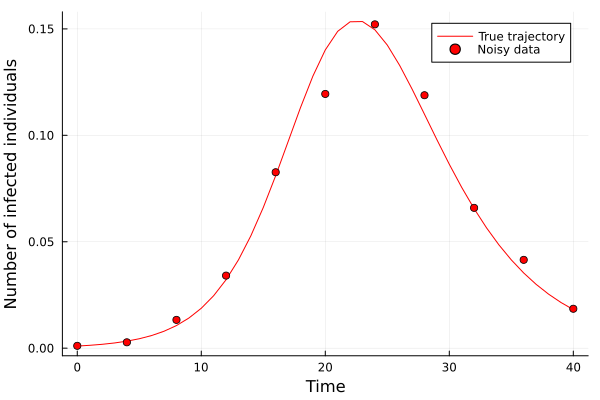

In [80]:
plot(t, X[2, :], xlabel = "Time", ylabel = "Number of infected individuals", color = :red, 
     label = "True trajectory")
scatter!(t[begin:4:end], X_noisy, color = :red, label = "Noisy data")

### Set up the UDE

We set up our UDE by first defining the NN component and then the hybrid model $u'=f(u)+\text{NN}(u)$.

In [81]:
# Define activation function
rbf(x) = exp.(-(x .^ 2))   

# Multi-layer feed-forward neural network
model = Chain(Dense(3, 5, rbf), Dense(5, 5, rbf), Dense(5, 5, rbf), Dense(5, 3))

# Get initial parameters and state variables of the model
p_init, st = Lux.setup(rng, model);

In [82]:
# Define the hybrid model
β, γ, N = p_ODE

function ude_dynamics!(du, u, p, t)
    nn = Lux.apply(model, u, p, st)[1]   # Network prediction    
    du[1] = nn[1]
    du[2] = -γ*u[2] + nn[2] 
    du[3] = γ*u[2] + nn[3]
end

prob_ude = ODEProblem(ude_dynamics!, u0, tspan, p_init);

### Set up the training

In [83]:
function predict(p, saveat = t[begin:4:end])   # p is the parameter of the NN and the ODE at the same time
    _prob = remake(prob_ude, p = p)
    Array(solve(_prob, Tsit5(), abstol = 1e-6, reltol = 1e-6, saveat = saveat,
                sensealg = QuadratureAdjoint(autojacvec=ReverseDiffVJP(true))))
end;

In [91]:
function loss(p)
    X̂ = predict(p)
    mean(abs2, X_noisy .- X̂[2, :])   # MSE loss
end;

In [104]:
losses = Float64[]

function callback(p, l)
    push!(losses, l)
    n_iter = length(losses)
    if n_iter % 50 == 0   
        println("Loss after $(n_iter) iterations: $(losses[end])")
    end
    return false
end;

### Train the UDE

In [105]:
adtype = AutoZygote()   # automatic differentiation
optf = OptimizationFunction((p, _) -> loss(p), adtype)
optprob = OptimizationProblem(optf, ComponentVector{Float64}(p_init));

In [106]:
res1 = solve(optprob, ADAM(), callback = callback, maxiters = 5000);

Loss after 50 iterations: 0.0018199952328841315
Loss after 100 iterations: 0.0013888464045678157
Loss after 150 iterations: 0.0013402384289156236
Loss after 200 iterations: 0.0013181659432441374
Loss after 250 iterations: 0.0013152167833261252
Loss after 300 iterations: 0.0013145580544897577
Loss after 350 iterations: 0.0013137677735414787
Loss after 400 iterations: 0.001312704546053485
Loss after 450 iterations: 0.0013112155521821406
Loss after 500 iterations: 0.0013090150454149877
Loss after 550 iterations: 0.0013055520975317953
Loss after 600 iterations: 0.0012999140691770455
Loss after 650 iterations: 0.0012922792918560581
Loss after 700 iterations: 0.0012881300328884257
Loss after 750 iterations: 0.0012875607128899188
Loss after 800 iterations: 0.001287132624472382
Loss after 850 iterations: 0.0012866253510459636
Loss after 900 iterations: 0.0012860173352997608
Loss after 950 iterations: 0.0012852785359201717
Loss after 1000 iterations: 0.0012843660908099241
Loss after 1050 iterat

In [ ]:
optprob2 = OptimizationProblem(optf, res1.u)
res2 = solve(optprob2, LBFGS(), callback = callback, maxiters = 500) #1500
p_trained = res2.u;

### Visualize the results

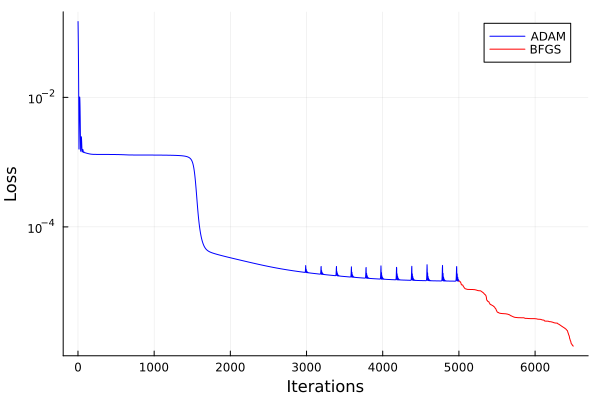

In [96]:
plot(1:5000, losses[1:5000], yaxis=:log10, xlabel="Iterations", ylabel="Loss", label="ADAM", color=:blue)
plot!(5001:length(losses), losses[5001:end], yaxis=:log10, label="BFGS", color=:red)

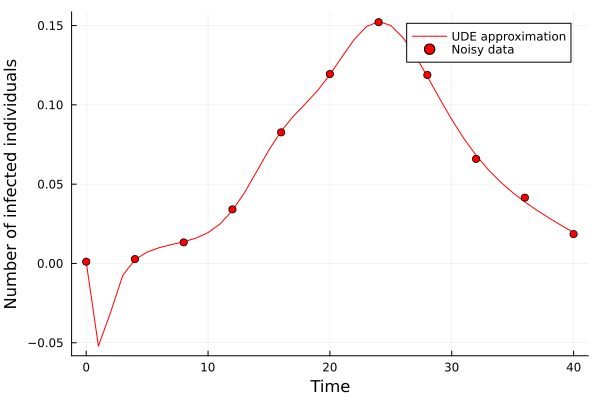

In [97]:
X̂ = predict(p_trained, t)
plot(t, X̂[2, :], xlabel = "Time", ylabel = "Number of infected individuals", color = :red, 
     label = "UDE approximation")
scatter!(t[begin:4:end], X_noisy, color = :red, label = "Noisy data")

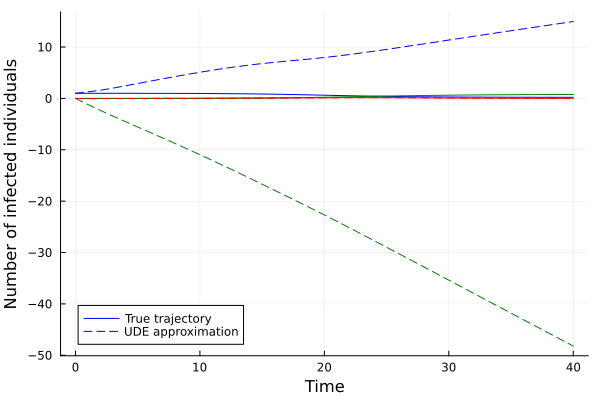

In [98]:
plot(t, X', xlabel = "Time", ylabel = "Number of infected individuals", color = [:blue :red :green], 
     label = ["True trajectory" nothing nothing])
plot!(t, X̂', color = [:blue :red :green], linestyle = :dash, label = ["UDE approximation" nothing nothing])

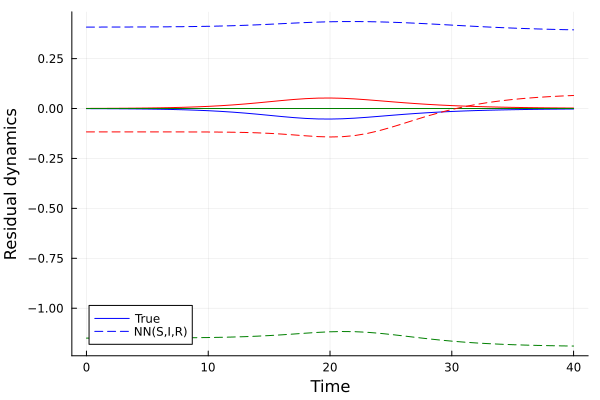

In [99]:
# True residual dynamics (i.e. interactions of predictors) along the true trajectory
dynamics_true = [-β/N * (X[1, :] .* X[2, :])'; β/N * (X[1, :] .* X[2, :])'; zeros(length(t))']
# Neural network guess along the true trajectory
dynamics_nn = Lux.apply(model, X, p_trained, st)[1]

plot(t, dynamics_true', xlabel = "Time", ylabel = "Residual dynamics", 
     color = [:blue :red :green], label = ["True" nothing nothing])
plot!(t, dynamics_nn', color = [:blue :red :green], linestyle = :dash, label = ["NN(S,I,R)" nothing nothing])